In [1]:
import os
os.getcwd()
os.chdir("../../..")
os.getcwd()

'/Users/calebchiam/Documents/GitHub/Cornell-Conversational-Analysis-Toolkit'

In [3]:
from graphviz import Digraph
import convokit
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

In [9]:
corpus = convokit.Corpus(filename=convokit.download("reddit-corpus-small"))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-corpus-small


In [11]:
threads = corpus.utterance_threads(prefix_len=10, include_root = False)

In [14]:
threads

{'e58slx0': {'e58slx0': Utterance({'id': 'e58slx0', 'user': User([('name', 'RedFaceGeneral')]), 'root': '9c8amk', 'reply_to': '9c8amk', 'timestamp': 1535851290, 'text': 'Fucking. Hot. Weather. ', 'meta': {'score': 95, 'top_level_comment': 'e58slx0', 'retrieved_on': 1538573577, 'gilded': 0, 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0}, 'subreddit': 'singapore', 'stickied': False, 'permalink': '/r/singapore/comments/9c8amk/what_are_your_biggest_complaints_about_singapore/e58slx0/', 'author_flair_text': ''}}),
  'e58yrci': Utterance({'id': 'e58yrci', 'user': User([('name', 'Eskipony')]), 'root': '9c8amk', 'reply_to': 'e58slx0', 'timestamp': 1535857949, 'text': 'we should just build a dome around singapore and air condition the whole country', 'meta': {'score': 41, 'top_level_comment': 'e58slx0', 'retrieved_on': 1538576460, 'gilded': 0, 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0}, 'subreddit': 'singapore', 'stickied': False, 'permalink': '/r/singapore/comments/9c8amk/what_are_your

In [12]:
hc = convokit.HyperConvo()


In [13]:
threads_motifs = hc.retrieve_motifs(corpus, prefix_len=10, include_root=False)

In [10]:
#list(threads_motifs.keys())[:10]

In [11]:
#threads_motifs['t1_c2yz6ed']

Let's construct a dictionary of triads from the threads:

In [12]:
next(iter(threads_motifs))

't1_c0od4pd'

In [6]:
list(convokit.MotifType)

[<MotifType.NO_EDGE_TRIADS: 1>,
 <MotifType.SINGLE_EDGE_TRIADS: 2>,
 <MotifType.INCOMING_TRIADS: 3>,
 <MotifType.OUTGOING_TRIADS: 4>,
 <MotifType.DYADIC_TRIADS: 5>,
 <MotifType.UNIDIRECTIONAL_TRIADS: 6>,
 <MotifType.INCOMING_2TO3_TRIADS: 7>,
 <MotifType.INCOMING_1TO3_TRIADS: 8>,
 <MotifType.DIRECTED_CYCLE_TRIADS: 9>,
 <MotifType.OUTGOING_3TO1_TRIADS: 10>,
 <MotifType.INCOMING_RECIPROCAL_TRIADS: 11>,
 <MotifType.OUTGOING_RECIPROCAL_TRIADS: 12>,
 <MotifType.DIRECTED_CYCLE_1TO3_TRIADS: 13>,
 <MotifType.DIRECIPROCAL_TRIADS: 14>,
 <MotifType.DIRECIPROCAL_2TO3_TRIADS: 15>,
 <MotifType.TRIRECIPROCAL_TRIADS: 16>]

In [7]:
triad_types = convokit.TriadMotif.get_motif_types()

AttributeError: type object 'TriadMotif' has no attribute 'get_motif_types'

In [14]:
triad_types

dict_keys(['NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'OUTGOING_TRIADS', 'DYADIC_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'INCOMING_2TO3_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECTED_CYCLE_TRIADS', 'OUTGOING_3TO1_TRIADS', 'INCOMING_RECIPROCAL_TRIADS', 'OUTGOING_RECIPROCAL_TRIADS', 'DIRECTED_CYCLE_1TO3_TRIADS', 'DIRECIPROCAL_TRIADS', 'DIRECIPROCAL_2TO3_TRIADS', 'TRIRECIPROCAL_TRIADS'])

In [15]:
from collections import defaultdict
triad_dict = defaultdict(list)

In [16]:
for thread in threads_motifs:
    for triad_type in threads_motifs[thread]:
        triad_dict[triad_type].extend(threads_motifs[thread][triad_type])

In [17]:
# Total number of distinct motifs found
total_motifs = 0
for triad_type in triad_dict:
    total_motifs += len(triad_dict[triad_type])
print(total_motifs)

2813655


Let's try to disambiguate motifs further according to their developmental paths:

In [18]:
def get_development_path(motif):
    path = []
    curr_motif_state = motif
    while curr_motif_state is not None:
        path.append(curr_motif_state.triad_type)
        curr_motif_state = curr_motif_state.regress()
    return tuple(path[::-1])

In [19]:
motif1 = triad_dict['TRIRECIPROCAL_TRIADS'][0]

In [20]:
motif1.edges[0]

[{'timestamp': 1267430163,
  'text': 'I edited my post a bit to contain more relevant information. Also, that other guy responding is kinda rude.\n\nGood luck quitting pot. I quit when the economy tanked incase I ever lose my job so I can easily pass a drug test right away.',
  'speaker': User([('name', 'edify')]),
  'target': User([('name', 'derb')]),
  'reply_to': 't1_c0lde4n',
  'top_level_comment': 't1_c0lddw0',
  'root': False}]

In [21]:
get_development_path(motif1)

('NO_EDGE_TRIADS',
 'SINGLE_EDGE_TRIADS',
 'OUTGOING_TRIADS',
 'OUTGOING_3TO1_TRIADS',
 'DIRECIPROCAL_TRIADS',
 'DIRECIPROCAL_2TO3_TRIADS',
 'TRIRECIPROCAL_TRIADS')

In [22]:
def viz_motif(motif, verbose=True, text_limit = None):
    g = Digraph('G')
    g.attr(rankdir='LR')
    edges = sorted([e[0] for e in motif.edges], key=lambda x: x['timestamp'])
    for idx, edge in enumerate(edges):
        if verbose:
            label = "{}. {}".format(idx + 1, edge['text']) if text_limit is None else "{}. {}".format(idx + 1, edge['text'][:text_limit]) 
        else:
            label = str(idx+1)
        g.edge(str(edge['speaker']), str(edge['target']), label=label)
    g.view()


In [23]:
viz_motif(motif1, text_limit=10)

We construct a dictionary of all paths:

In [24]:
path_dict = defaultdict(list)

Let one of the hypernodes in the triad motif be a User posting a top level comment (edge not present in triad motif.) Restrict the motifs to those where two “response to top level comment” edges exist. By definition, these are the motifs where we have 1 hypernode where the User posted a top level comment, and 2 hypernodes representing Users who responded to this User.

In [25]:
for motif_type, motif_instances in triad_dict.items():
    for motif_instance in motif_instances:
        
        if len(motif_instance.edges) == 0: continue 
        num_replies_to_root = 0
        
        for edge_set in motif_instance.edges:
            if edge_set[0]['root']: 
                num_replies_to_root += 1
        if num_replies_to_root == 2: # as per above paragraph
            path_dict[get_development_path(motif_instance)].append(motif_instance)

In [26]:
# Total number of path instances, should be fewer than motif instances since we constrain it to start 
# with an utterance directed at top_level_comment
def get_num_paths(path_dict):
    total_paths = 0
    for path_type, path_instances in path_dict.items():
        total_paths += len(path_instances)
    return total_paths

print(get_num_paths(path_dict))

252190


In [27]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')

<Figure size 6400x4800 with 0 Axes>

<Figure size 6400x4800 with 0 Axes>

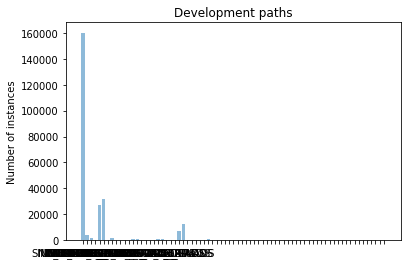

In [28]:
num_path_instances = [len(path_dict[k]) for k in path_dict]
y_pos = range(len(path_dict))
graph = plt.bar(y_pos, num_path_instances, align='center', alpha=0.5)
plt.xticks(y_pos, triad_dict.keys())
plt.ylabel('Number of instances')
plt.title('Development paths')
plt.rcParams["figure.figsize"] = (30,50)
plt.show()


In [29]:
# Number of paths
print(len(path_dict))


73


In [30]:
pd = {k: len(v) for k, v in path_dict.items()}
end_state = defaultdict(int)
for path, count in pd.items():
    end_state[path[-1]] += count

In [31]:
end_state

defaultdict(int,
            {'INCOMING_TRIADS': 160292,
             'INCOMING_2TO3_TRIADS': 5684,
             'INCOMING_1TO3_TRIADS': 59253,
             'INCOMING_RECIPROCAL_TRIADS': 1899,
             'OUTGOING_RECIPROCAL_TRIADS': 1393,
             'DIRECTED_CYCLE_1TO3_TRIADS': 1366,
             'DIRECIPROCAL_TRIADS': 19836,
             'DIRECIPROCAL_2TO3_TRIADS': 2108,
             'TRIRECIPROCAL_TRIADS': 359})

In [32]:
for path in path_dict:
    print(path)
    print(len(path_dict[path]))

('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS')
160292
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'INCOMING_2TO3_TRIADS')
4131
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'INCOMING_2TO3_TRIADS')
1548
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'OUTGOING_TRIADS', 'INCOMING_2TO3_TRIADS')
5
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS')
27285
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'INCOMING_1TO3_TRIADS')
31944
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'INCOMING_1TO3_TRIADS')
24
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'INCOMING_2TO3_TRIADS', 'INCOMING_RECIPROCAL_TRIADS')
1393
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'OUTGOING_3TO1_TRIADS', 'INCOMING_RECIPROCAL_TRIADS')
226
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'INCOMING_2TO3_TRIADS', 'INCOMING_RECIPROCAL_TRIADS')
138
('NO_EDGE_TRIADS', 'SINGL

In [33]:
motif2 = path_dict[('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECIPROCAL_TRIADS', 'DIRECIPROCAL_2TO3_TRIADS')][2]

In [34]:
def replay_motif(motif):
    pathway = get_development_path(motif)
    sorted_edges = sorted(motif.edges, key=lambda e: e[0]['timestamp'])
    for i in range(len(pathway)):
        if i == 0: continue
        print("########################")
        print("{} -> {}".format(pathway[i-1], pathway[i]))
        print()
        edge = sorted_edges[i-1][0]
        print("{} <- {}".format(edge['target'], edge['speaker']))
        print()
        print("TEXT: {}".format(edge['text']))
        print()
        if edge['root']:
            print("(This utterance responds to a top-level-comment!)")
            print()

In [35]:
def display_motif(motif):
    print(motif.triad_type)
    print()
    labels = motif.labels
    edges = [e[0]['text'] for e in motif.edges]
    
    for i in range(len(labels)):
        print(labels[i])
        print(edges[i])
        print()

In [36]:
replay_motif(motif2)

########################
NO_EDGE_TRIADS -> SINGLE_EDGE_TRIADS

User([('name', 'honestbleeps')]) <- User([('name', '[deleted-t1_c0rfz09]')])

TEXT: Vs also said show me the rulebook. Goalies on ANY team are given a lot of lead on the physical presence on the net. Know why? cause they aren't big ass forwards.

Again, your team would get less calls if they weren't coming in with a young and brazen attitude about when to be aggressive. Keep it on the down low. Either way, it's hockey suck it up

(This utterance responds to a top-level-comment!)

########################
SINGLE_EDGE_TRIADS -> DYADIC_TRIADS

User([('name', '[deleted-t1_c0rfz09]')]) <- User([('name', 'honestbleeps')])

TEXT: A stick to the face is a penalty every single time except on a shot follow through.

Go read the rulebook.

########################
DYADIC_TRIADS -> INCOMING_1TO3_TRIADS

User([('name', 'honestbleeps')]) <- User([('name', 'SteveJankowski1')])

TEXT: Flyers got away with another hook on Ladd in the slot j

In [37]:
viz_motif(motif2, text_limit = 30)

In [38]:
spec = threads['t1_c2zdwxx']
hg = hc._make_hypergraph(uts=spec)
hg.extract_motifs()

{'NO_EDGE_TRIADS': [],
 'SINGLE_EDGE_TRIADS': [],
 'INCOMING_TRIADS': [],
 'OUTGOING_TRIADS': [],
 'DYADIC_TRIADS': [],
 'UNIDIRECTIONAL_TRIADS': [],
 'INCOMING_2TO3_TRIADS': [],
 'INCOMING_1TO3_TRIADS': [],
 'DIRECTED_CYCLE_TRIADS': [],
 'OUTGOING_3TO1_TRIADS': [],
 'INCOMING_RECIPROCAL_TRIADS': [],
 'OUTGOING_RECIPROCAL_TRIADS': [],
 'DIRECTED_CYCLE_1TO3_TRIADS': [],
 'DIRECIPROCAL_TRIADS': [],
 'DIRECIPROCAL_2TO3_TRIADS': [<convokit.triadMotif.TriadMotif at 0x1ad200be0>],
 'TRIRECIPROCAL_TRIADS': []}

In [39]:
motif3 = hg.extract_motifs()['DIRECIPROCAL_2TO3_TRIADS'][0]

In [40]:
viz_motif(motif3, text_limit=40)

In [41]:
display_motif(motif3)

DIRECIPROCAL_2TO3_TRIADS

C1->C2
That's not logical.  R/MR is one of few reddits where people don't buy into the mainstream bullshit view (that men are evil and women are all victims).  Therefore it is a place where there will be some people who are smart enough and open-minded enough to realize that men's rights is part of a larger issue.

Spending my time here is more valuable than going around posting links at every sub-reddit, obviously.

C2->C1
By that logic, you should go x-post this to every subreddit here, every single one, because the race can impact all of them. Get to work.

C1->C3
It's not unrelated, and it's not spam.  Just because you don't agree with it doesn't make it unrelated or not spam.  Learn a little reddiquette.

The presidential race will have significant effects on the path our country takes and our boys will suffer greatly if we elect a president that gets us involved in unnecessary wars.  The only presidential candidate who respects the constitution is Ron Pa

In [42]:
replay_motif(motif3)

########################
NO_EDGE_TRIADS -> SINGLE_EDGE_TRIADS

User([('name', 'memymineown')]) <- User([('name', 'drinkthebleach')])

TEXT: Every single thread with this crap, same guy too. It's not that I don't agree with it, I just hate seeing my favorite subreddit polluted with unrelated bullshit. You don't need to go the Jehova's Witness route, seriously, it doesn't help.

(This utterance responds to a top-level-comment!)

########################
SINGLE_EDGE_TRIADS -> INCOMING_TRIADS

User([('name', 'memymineown')]) <- User([('name', 'thingsarebad')])

TEXT: It's not unrelated, and it's not spam.  Just because you don't agree with it doesn't make it unrelated or not spam.  Learn a little reddiquette.

The presidential race will have significant effects on the path our country takes and our boys will suffer greatly if we elect a president that gets us involved in unnecessary wars.  The only presidential candidate who respects the constitution is Ron Paul.  Vote for anyone else and 

In [43]:
viz_motif(motif1, text_limit = 40)

In [44]:
replay_motif(motif1)

########################
NO_EDGE_TRIADS -> SINGLE_EDGE_TRIADS

User([('name', 'edify')]) <- User([('name', 'derb')])

TEXT: cool, i've got a few things waiting to be watched. thanks.

(This utterance responds to a top-level-comment!)

########################
SINGLE_EDGE_TRIADS -> OUTGOING_TRIADS

User([('name', 'derb')]) <- User([('name', 'edify')])

TEXT: I edited my post a bit to contain more relevant information. Also, that other guy responding is kinda rude.

Good luck quitting pot. I quit when the economy tanked incase I ever lose my job so I can easily pass a drug test right away.

########################
OUTGOING_TRIADS -> OUTGOING_3TO1_TRIADS

User([('name', 'edify')]) <- User([('name', '[deleted-t1_c0lddw0]')])

TEXT: [deleted]

########################
OUTGOING_3TO1_TRIADS -> DIRECIPROCAL_TRIADS

User([('name', '[deleted-t1_c0lddw0]')]) <- User([('name', 'edify')])

TEXT: Hey I understand the drunk thing totally. Might want to cool your jets a bit though.... derb is just as

# Relaxing conditions

If we do the math, we find that we have 1220 motifs with triadic closure. Probably a fair bit less if we exclude motifs that have edges with deleted texts. Let's relax the condition by having the "User posting a top level comment" be relaxed to "User posting any comment" and having two other Users respond to that.

In [45]:
path_dict2 = defaultdict(list)

In [46]:
triad_dict.keys()

dict_keys(['NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'OUTGOING_TRIADS', 'DYADIC_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'INCOMING_2TO3_TRIADS', 'INCOMING_1TO3_TRIADS', 'DIRECTED_CYCLE_TRIADS', 'OUTGOING_3TO1_TRIADS', 'INCOMING_RECIPROCAL_TRIADS', 'OUTGOING_RECIPROCAL_TRIADS', 'DIRECTED_CYCLE_1TO3_TRIADS', 'DIRECIPROCAL_TRIADS', 'DIRECIPROCAL_2TO3_TRIADS', 'TRIRECIPROCAL_TRIADS'])

In [47]:
for motif_type, motif_instances in triad_dict.items():
    for motif_instance in motif_instances:
        if len(motif_instance.edges) == 0: continue 
        num_replies_to_root = 0
        
        utts_replied_to = [edge_set[0]['reply_to'] for edge_set in motif_instance.edges]
        if max(Counter(utts_replied_to).values()) == 2:
            path_dict2[get_development_path(motif_instance)].append(motif_instance)

We now have the machinery to do more interesting analyses:

In [48]:
get_num_paths(path_dict2)

389411

In [49]:
print(len(path_dict2))

86


In [50]:
pd2 = {k: len(v) for k, v in path_dict2.items()}
end_state = defaultdict(int)
for path, count in pd2.items():
    end_state[path[-1]] += count

In [51]:
end_state

defaultdict(int,
            {'INCOMING_TRIADS': 220028,
             'INCOMING_2TO3_TRIADS': 7249,
             'INCOMING_1TO3_TRIADS': 112020,
             'INCOMING_RECIPROCAL_TRIADS': 2297,
             'OUTGOING_RECIPROCAL_TRIADS': 2425,
             'DIRECTED_CYCLE_1TO3_TRIADS': 3403,
             'DIRECIPROCAL_TRIADS': 36788,
             'DIRECIPROCAL_2TO3_TRIADS': 4488,
             'TRIRECIPROCAL_TRIADS': 713})

In [52]:
pd2

{('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS'): 220028,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS'): 5190,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'UNIDIRECTIONAL_TRIADS',
  'INCOMING_2TO3_TRIADS'): 2024,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'OUTGOING_TRIADS',
  'INCOMING_2TO3_TRIADS'): 35,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'DYADIC_TRIADS',
  'INCOMING_1TO3_TRIADS'): 57051,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_1TO3_TRIADS'): 44171,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'UNIDIRECTIONAL_TRIADS',
  'INCOMING_1TO3_TRIADS'): 10798,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS',
  'INCOMING_RECIPROCAL_TRIADS'): 1669,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'UNIDIRECTIONAL_TRIADS',
  'OUTGOING_3TO1_TRIADS',
  'INCOMING_RECIPROCAL_TRIADS'): 259,
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'UNIDIRECTIONAL_TRIA

In [53]:
for path in path_dict2:
    print(path)
    print(len(path_dict2[path]))

('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS')
220028
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'INCOMING_2TO3_TRIADS')
5190
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'INCOMING_2TO3_TRIADS')
2024
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'OUTGOING_TRIADS', 'INCOMING_2TO3_TRIADS')
35
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS')
57051
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'INCOMING_1TO3_TRIADS')
44171
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'INCOMING_1TO3_TRIADS')
10798
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'INCOMING_2TO3_TRIADS', 'INCOMING_RECIPROCAL_TRIADS')
1669
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'OUTGOING_3TO1_TRIADS', 'INCOMING_RECIPROCAL_TRIADS')
259
('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'UNIDIRECTIONAL_TRIADS', 'INCOMING_2TO3_TRIADS', 'INCOMING_RECIPROCAL_TRIADS')
167
('NO_EDGE_TRIADS', 'S

Excluding non-triadic closure motifs, this gives a total of 2046 motifs with triadic closure to work with.

Once we filter out [deleted]'s, we remove 614 motif instances, giving us 1432 motifs to work with. (Filtering step not shown here.)

In [54]:
def has_deleted_text(motif_inst):
    for edge in motif_inst.edges:
        if edge[0]['text'] == "[deleted]":
            return True
    return False

To visualize some of these to verify correctness:

In [55]:
# for path, instances in path_dict2_trunc.items():
#     motif_a = instances[0]
#     print(motif_a.edges[0][0]['top_level_comment'])
#     viz_motif(motif_a, text_limit=40)
#     replay_motif(motif_a)
#     print()
#     input()

NameError: name 'path_dict2_trunc' is not defined

# Predictive tasks

Let's see if we can predict when triadic closure happens. As triadic closure happens at different points in a triad's development, we have to take care to compare like-to-like and that we are examining the same kind of triadic closure; incoming / unidirectional / outgoing -> incoming_2to3 are three different types of triadic closure, for example.

Let's focus more on the '2to3' type of triadic closure, as in: 
- incoming -> incoming_2to3 
- direciprocal -> direciprocal_2to3
- incoming_1to3 -> outgoing_reciprocal

In [ ]:
# for k in path_dict2_trunc:
#     print(k)

## Incoming vs incoming_2to3

In [56]:
threads_motifs['t1_c2yz6ed']

{'NO_EDGE_TRIADS': [<convokit.triadMotif.TriadMotif at 0x140397e80>],
 'SINGLE_EDGE_TRIADS': [],
 'INCOMING_TRIADS': [],
 'OUTGOING_TRIADS': [],
 'DYADIC_TRIADS': [],
 'UNIDIRECTIONAL_TRIADS': [],
 'INCOMING_2TO3_TRIADS': [],
 'INCOMING_1TO3_TRIADS': [],
 'DIRECTED_CYCLE_TRIADS': [],
 'OUTGOING_3TO1_TRIADS': [],
 'INCOMING_RECIPROCAL_TRIADS': [],
 'OUTGOING_RECIPROCAL_TRIADS': [],
 'DIRECTED_CYCLE_1TO3_TRIADS': [],
 'DIRECIPROCAL_TRIADS': [<convokit.triadMotif.TriadMotif at 0x140397eb8>,
 'DIRECIPROCAL_2TO3_TRIADS': [],
 'TRIRECIPROCAL_TRIADS': []}

In [57]:
# Generate a dict of thread_ids to motifs (disambiguated by paths)
threads_paths = defaultdict(dict)
for thread, motif_dict in threads_motifs.items():
    for motif_type_instances in motif_dict.values():
        for motif_inst in motif_type_instances:
            path = get_development_path(motif_inst)
            if path not in threads_motifs[thread]:
                threads_paths[thread][path] = [motif_inst]
            else:
                threads_paths[thread][path].append(motif_inst)

In [ ]:
pd2

In [82]:
def responds_to_same_utt(motif_instance):
    utts_replied_to = [edge_set[0]['reply_to'] for edge_set in motif_instance.edges]
    return max(Counter(utts_replied_to).values())
        

In [83]:
import random

def generate_pos_neg(threads_paths, pos_types, neg_types):
    pos, neg = [], []
    for thread in threads_paths: # thread is top-level-comment
        paths = threads_paths[thread]
#         print(paths)
        pos_instances = [triad_instance for pos_type in pos_types for triad_instance in paths.get(pos_type, []) 
                         if not has_deleted_text(triad_instance) and responds_to_same_utt(triad_instance)]
        neg_instances = [triad_instance for neg_type in neg_types for triad_instance in paths.get(neg_type, []) 
                         if not has_deleted_text(triad_instance) and responds_to_same_utt(triad_instance)]
        
#         print(len(pos_instances), len(neg_instances))
        if len(pos_instances) == 0 or len(neg_instances) == 0: continue
        
        pos.append(random.choice(pos_instances))
        neg.append(random.choice(neg_instances))
        
    print("- {} positive, {} negative pts".format(len(pos), len(neg)))  
    return pos, neg


In [59]:
pos_types = []
for k in pd2:
    if str(k).startswith("('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS', 'INCOMING_2TO3_TRIADS'"):
        pos_types.append(k)
pos_types

[('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS'),
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS',
  'INCOMING_RECIPROCAL_TRIADS'),
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS',
  'OUTGOING_RECIPROCAL_TRIADS'),
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS',
  'DIRECTED_CYCLE_1TO3_TRIADS'),
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS',
  'INCOMING_RECIPROCAL_TRIADS',
  'DIRECIPROCAL_2TO3_TRIADS'),
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS',
  'DIRECTED_CYCLE_1TO3_TRIADS',
  'DIRECIPROCAL_2TO3_TRIADS'),
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMING_2TO3_TRIADS',
  'OUTGOING_RECIPROCAL_TRIADS',
  'DIRECIPROCAL_2TO3_TRIADS'),
 ('NO_EDGE_TRIADS',
  'SINGLE_EDGE_TRIADS',
  'INCOMING_TRIADS',
  'INCOMI

In [84]:
pos, neg = generate_pos_neg(threads_paths, 
                            pos_types = pos_types, 
                            neg_types = [('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS')]
                           )

- 4881 positive, 4881 negative pts


In [85]:
viz_motif(random.choice(pos))

### BOW

In [61]:
ys = [1]*len(pos) + [0]*len(neg)

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split

random.seed(42)

motifs_text = []
for motif_inst in pos + neg:
    # BOW baseline text
    # motif_text taken from first two edges
    time_sorted_edges = sorted([e[0] for e in motif_inst.edges], key=lambda x: x['timestamp'])
    text1 = " ".join(["1_"+w for w in time_sorted_edges[0]['text'].split(" ")])
    text2 = " ".join(["2_"+w for w in time_sorted_edges[1]['text'].split(" ")])
    motif_text = text1 + " " + text2
    motifs_text.append(motif_text)
    
text_train, text_test, y_train, y_test = train_test_split(motifs_text, ys, test_size=0.3, random_state=42)
cv = CountVectorizer(min_df=0.05, max_df=0.8, ngram_range=(1, 3)) # excluding stop_words field improves performance
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)
        
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("- BOW: {:.4f} train, {:.4f} test".format(train_acc, test_acc))

- BOW: 0.5693 train, 0.5015 test


In [ ]:
words_coefs = sorted(list(zip(cv.get_feature_names(), clf.coef_[0])), key=lambda x: abs(x[1]), reverse=True)

In [ ]:
words_coefs

In [77]:
X_test

<2929x207 sparse matrix of type '<class 'numpy.int64'>'
	with 82043 stored elements in Compressed Sparse Row format>

### Time diff between first/second edge, length of first edge text, length of second edge text

In [80]:
def get_features_from_motif(motif_inst):
    time_sorted_edges = sorted([e[0] for e in motif_inst.edges], key=lambda x: x['timestamp'])
    time_diff = time_sorted_edges[1]['timestamp'] - time_sorted_edges[0]['timestamp']
    num_words_1 = len(list(time_sorted_edges[0]['text'].split(" ")))
    num_words_2 = len(list(time_sorted_edges[1]['text'].split(" ")))
    return [time_diff, num_words_1, num_words_2]

In [81]:
X2 = []
for motif_inst in pos + neg:
    X2.append(get_features_from_motif(motif_inst))

X2 = np.array(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, ys, test_size=0.2, random_state=42)
        
clf = LogisticRegression(solver="liblinear")
clf.fit(X2_train, y2_train)

train_acc = clf.score(X2_train, y2_train)
test_acc = clf.score(X2_test, y2_test)
print("- Basic features: {:.4f} train, {:.4f} test".format(train_acc, test_acc))

- Basic features: 0.5077 train, 0.5141 test


### BOW + Basic features

In [71]:
X2 = []
for motif_inst in pos + neg:
    X2.append(get_features_from_motif(motif_inst))

X_combi = list(zip(motifs_text, X2))

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_combi, ys, test_size=0.2, random_state=42)
cv = CountVectorizer(min_df=0.05, max_df=0.8, ngram_range=(1,2)) 
X_bow_train = cv.fit_transform([x[0] for x in X_train]).todense()
X_bow_test = cv.transform([x[0] for x in X_test]).todense()

X_combi_train = []
X_combi_test = []
# print(X_bow_train[0].tolist()[0])

for row in range(len(X_train)):
    X_combi_train.append(X_bow_train[row].tolist()[0] + X_train[row][1])

for row in range(len(X_test)):
    X_combi_test.append(X_bow_test[row].tolist()[0] + X_test[row][1])

X_combi_train = np.array(X_combi_train)
X_combi_test = np.array(X_combi_test)
# print(X_combi_train)
clf = LogisticRegression(solver="liblinear")
clf.fit(X_combi_train, y_train)

print(X_combi_train.shape)

train_acc = clf.score(X_combi_train, y_train)
test_acc = clf.score(X_combi_test, y_test)
print("- Combined: {:.4f} train, {:.4f} test".format(train_acc, test_acc))

(7809, 212)
- Combined: 0.5079 train, 0.5141 test


### Tightening conditions

No better than chance. Maybe if we focus on those that include the User that posts a top-level-comment?

In [89]:
def responds_to_same_toplvlcomm(motif_instance):
    num_replies_to_root = 0
    for edge_set in motif_instance.edges:
        if edge_set[0]['root']: 
            num_replies_to_root += 1
    return num_replies_to_root==2

In [90]:
def generate_pos_neg2(threads_paths, pos_types, neg_types):
    pos, neg = [], []
    for thread in threads_paths: # thread is top-level-comment
        paths = threads_paths[thread]
#         print(paths)
        pos_instances = [triad_instance for pos_type in pos_types for triad_instance in paths.get(pos_type, []) 
                         if not has_deleted_text(triad_instance) and responds_to_same_toplvlcomm(triad_instance)]
        neg_instances = [triad_instance for neg_type in neg_types for triad_instance in paths.get(neg_type, []) 
                         if not has_deleted_text(triad_instance) and responds_to_same_toplvlcomm(triad_instance)]
        
#         print(len(pos_instances), len(neg_instances))
        if len(pos_instances) == 0 or len(neg_instances) == 0: continue
        
        pos.append(random.choice(pos_instances))
        neg.append(random.choice(neg_instances))
        
    print("- {} positive, {} negative pts".format(len(pos), len(neg)))  
    return pos, neg



In [91]:
pos, neg = generate_pos_neg2(threads_paths, 
                            pos_types = pos_types, 
                            neg_types = [('NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'INCOMING_TRIADS')]
                           )

- 2068 positive, 2068 negative pts


### BOW

In [101]:
ys = [1]*len(pos) + [0]*len(neg)
random.seed(42)

motifs_text = []
for motif_inst in pos + neg:
    # BOW baseline text
    # motif_text taken from first two edges
    time_sorted_edges = sorted([e[0] for e in motif_inst.edges], key=lambda x: x['timestamp'])
    text1 = " ".join([w for w in time_sorted_edges[0]['text'].split(" ")])
    text2 = " ".join([w for w in time_sorted_edges[1]['text'].split(" ")])
    motif_text = text1 + " " + text2
    motifs_text.append(motif_text)
    
text_train, text_test, y_train, y_test = train_test_split(motifs_text, ys, test_size=0.2, random_state=42)
cv = CountVectorizer(min_df=0.05, max_df=0.8, ngram_range=(1, 3)) # excluding stop_words field improves performance
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)
        
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("- BOW: {:.4f} train, {:.4f} test".format(train_acc, test_acc))

#57% train and test accuracy (text1/text2 not distinguished, 0.05 / 0.8, no stop_words)

- BOW: 0.5674 train, 0.4300 test


In [98]:
words_coefs = sorted(list(zip(cv.get_feature_names(), clf.coef_[0])), key=lambda x: abs(x[1]), reverse=True)

In [99]:
words_coefs

[('http www', 0.4956121253877387),
 ('lot of', -0.4600664103238561),
 ('www', -0.4199982212408819),
 ('lot', 0.3113368210218197),
 ('com', -0.2554050969127475),
 ('same', 0.24615385805683107),
 ('the same', -0.24227804352563087),
 ('always', -0.2382392453696565),
 ('doesn', 0.21521607242057392),
 ('while', -0.19764507361511213),
 ('down', -0.19445281453510485),
 ('want to', 0.1941579635531496),
 ('used', 0.19052167653685806),
 ('before', -0.1783387060299004),
 ('going to', 0.17270620728318525),
 ('very', -0.1668998008213649),
 ('pretty', -0.16169305023769953),
 ('someone', -0.1616570593927834),
 ('makes', -0.15618035158218557),
 ('on the', -0.1498651116627687),
 ('feel', 0.14970764035232853),
 ('many', 0.14923751049772507),
 ('point', 0.14594687445944615),
 ('go', 0.13738701354684216),
 ('am', 0.1349866972203328),
 ('isn', 0.13396258226288685),
 ('its', -0.13164051423409848),
 ('should', 0.12793384710948924),
 ('said', 0.12606088752200018),
 ('bad', 0.12602018430285528),
 ('is that', 0

### Basic features

In [105]:
X2 = []
for motif_inst in pos + neg:
    X2.append(get_features_from_motif(motif_inst))

X2 = np.array(X2)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, ys, test_size=0.3, random_state=42)
        
clf = LogisticRegression(solver="liblinear")
clf.fit(X2_train, y2_train)

train_acc = clf.score(X2_train, y2_train)
test_acc = clf.score(X2_test, y2_test)
print("- Basic features: {:.4f} train, {:.4f} test".format(train_acc, test_acc))

- Basic features: 0.5047 train, 0.5189 test


### Combined

In [106]:
X2 = []
for motif_inst in pos + neg:
    X2.append(get_features_from_motif(motif_inst))

X_combi = list(zip(motifs_text, X2))

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_combi, ys, test_size=0.3, random_state=42)
cv = CountVectorizer(min_df=0.05, max_df=0.8, ngram_range=(1,3)) 
X_bow_train = cv.fit_transform([x[0] for x in X_train]).todense()
X_bow_test = cv.transform([x[0] for x in X_test]).todense()

X_combi_train = []
X_combi_test = []
# print(X_bow_train[0].tolist()[0])

for row in range(len(X_train)):
    X_combi_train.append(X_bow_train[row].tolist()[0] + X_train[row][1])

for row in range(len(X_test)):
    X_combi_test.append(X_bow_test[row].tolist()[0] + X_test[row][1])

X_combi_train = np.array(X_combi_train)
X_combi_test = np.array(X_combi_test)
# print(X_combi_train)
clf = LogisticRegression(solver="liblinear")
clf.fit(X_combi_train, y_train)

print(X_combi_train.shape)

train_acc = clf.score(X_combi_train, y_train)
test_acc = clf.score(X_combi_test, y_test)
print("- Combined: {:.4f} train, {:.4f} test".format(train_acc, test_acc))

(2895, 223)
- Combined: 0.5029 train, 0.5197 test



As one of the features the identified subreddits from thread_randomizer consistently differed from the norm from was: DIRECIPROCAL_2to3, let's pick any one and try to elucidate what are the key words used in a DIRECIPROCAL_2TO3 triad.

Let's try: **MensRights**

In [ ]:
def get_subreddit(threads, thread_id):
    if thread_id not in threads:
        return None
    return threads[thread_id][thread_id].other["user-info"]["subreddit"]

MensRights_threads = [thread_id for thread_id in threads if get_subreddit(threads, thread_id) == "MensRights"]

In [ ]:
def display_thread_helper(thread, root, indent=0):
    print(" "*indent + thread[root].user.name)
    print(" "*indent + thread[root].text.replace("\n", " "))
    children = [k for k, v in thread.items() if v.reply_to == root]
    for child in children:
        display_thread_helper(thread, child, indent=indent+4)
        
def display_thread(threads, root):
    return display_thread_helper(threads[root],root)

In [ ]:
for thread in MensRights_threads[:100]:
    if print_utterances(threads_motifs, thread, "DIRECIPROCAL_2TO3_TRIADS"):
        print(thread)
        print('###################DISPLAYING THREAD###################')
        display_thread(threads, thread)
        print()


Ordering of utterances: *(C1->C2, C2->C1, C1->C3, C3->C1, C2->C3)*